# Energy Consumption Using Time Series Forecasting 

## Yahia_Chammami

- The Data we will be using is Hourly Power Consumption Data from PJM 2002-2018 .
- PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States, Operating an Electric Transmission System serving all or parts of the entire east region . 
- Energy Consumtion Data Has Some unique charachteristics. It will be interesting to see how our Model will picks them up .


## Importing Required Libraries :

In [273]:
# Importing Required Libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [274]:
# Loading And Reading Dataset
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Feature Information :
- Datetime : Date 
- Pjme_mw : Megawatt Energy Consumption

In [275]:
# Checking the duplicate Records
df.duplicated().sum()

0

In [276]:
# Checking the basic information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [277]:
# Checking the shape of the dataset
df.shape

(145366, 2)

In [278]:
# Checking the basic Statistics for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.0,62009.0


In [279]:
# Indexing Dataset
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

## Data Exploration :

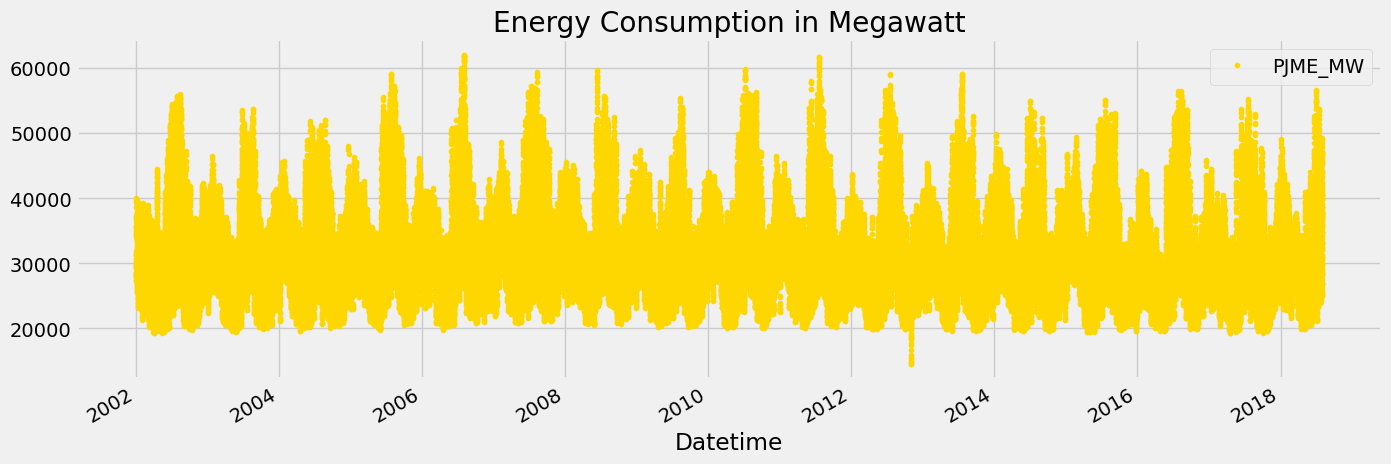

In [280]:
# Analysis : Evolution Of Energy Use from 2002-2018 
df.plot(style='.',
        figsize=(15, 5),
        color= "Gold",
        title='Energy Consumption in Megawatt')
plt.show()

### Time Series Features :

In [281]:
# Create Time Series Features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    return df

df1 = create_features(df)
df1.head()

,PJME_MW,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


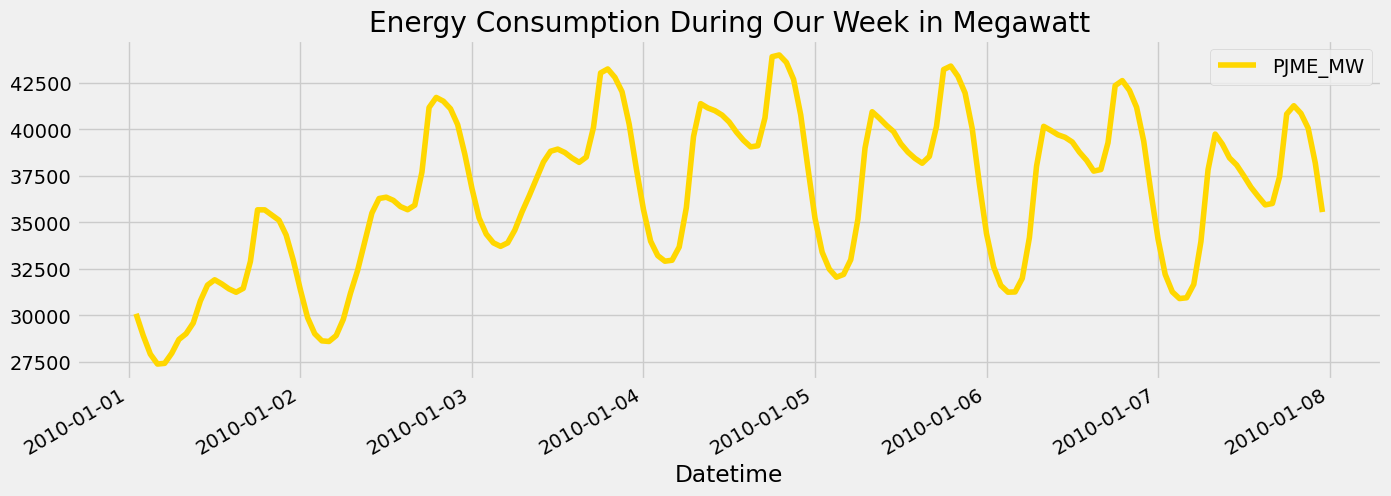

In [282]:
# Analysis : Evolution Of the Time series during the Week 01-01-2010 / 01-08-2010
En_Week = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] 
En_Week.plot(figsize=(15, 5),  color= "Gold", title='Energy Consumption During Our Week in Megawatt')
plt.show()

In [283]:
# Years With The Highest Energy Consumption in Megawatt 
df_year = df1.groupby(['year']).sum()['PJME_MW']
df_year.sort_values( ascending=False).head()

year
2007    294386758.0
2005    291733172.0
2010    289866969.0
2008    289187689.0
2006    283840384.0
Name: PJME_MW, dtype: float64

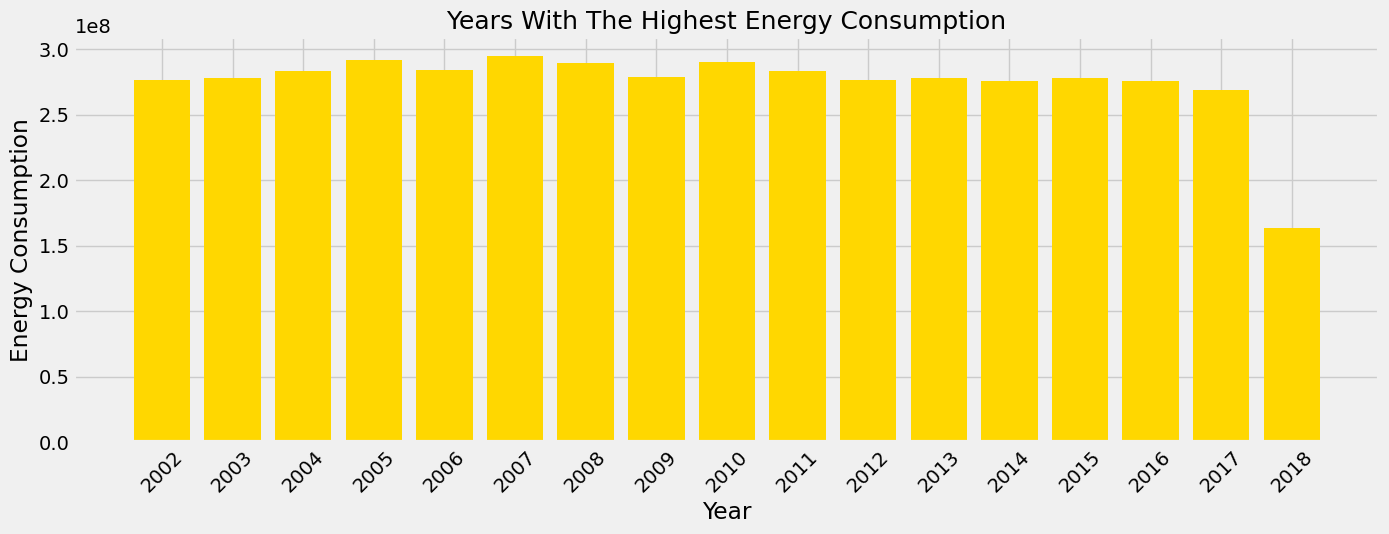

In [284]:
# Years With The Highest Energy Consumption in Megawatt 
Year_ = range(2002,2019)
plt.figure(figsize=(15, 5))
plt.bar(Year_,df_year,color= "Gold")
plt.xticks(Year_)
plt.ylabel('Energy Consumption')
plt.xlabel('Year')
plt.title(' Years With The Highest Energy Consumption ', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [285]:
# Months With The Highest Energy Consumption in Megawatt
df_month = df1.groupby(['month']).sum()['PJME_MW']
df_month.sort_values( ascending=False).head()

month
7     479131193.0
8     437431506.0
1     434339038.0
6     413856422.0
12    388945376.0
Name: PJME_MW, dtype: float64

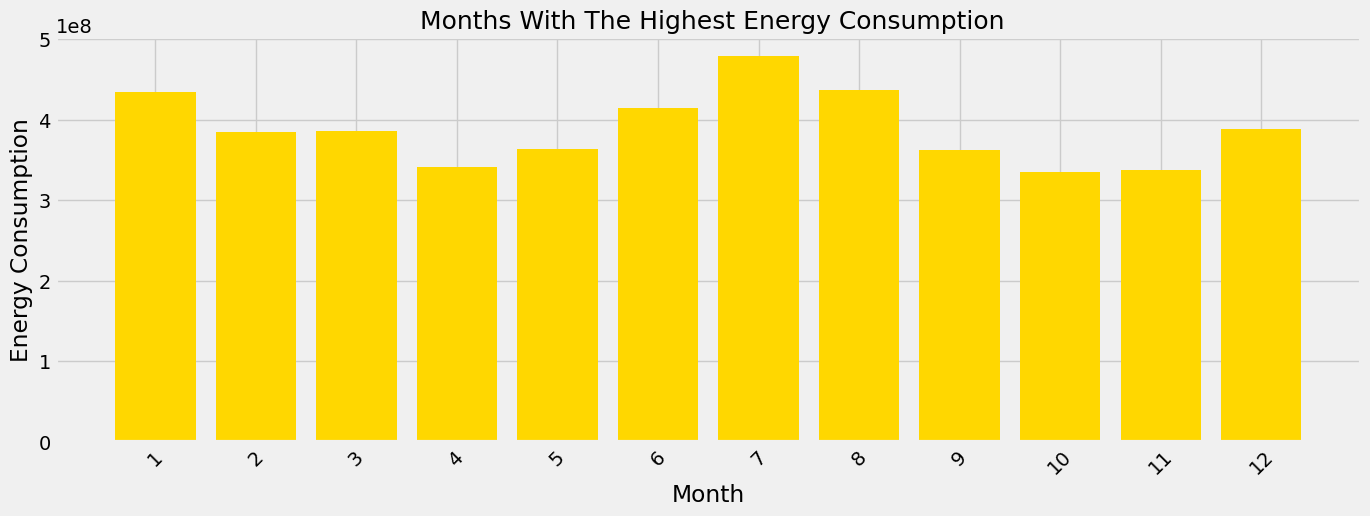

In [286]:
# Months With The Highest Energy Consumption in Megawatt
month_ = range(1,13)
plt.figure(figsize=(15, 5))
plt.bar(month_,df_month, color= "Gold")
plt.xticks(month_)
plt.ylabel('Energy Consumption')
plt.xlabel('Month')
plt.title(' Months With The Highest Energy Consumption', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [287]:
# Hours With The Highest Energy Consumption in Megawatt
df_hour = df1.groupby(['hour']).sum()['PJME_MW']
df_hour.sort_values( ascending=False).head()

hour
19    220672524.0
18    220644061.0
20    218735238.0
21    216519325.0
17    215640880.0
Name: PJME_MW, dtype: float64

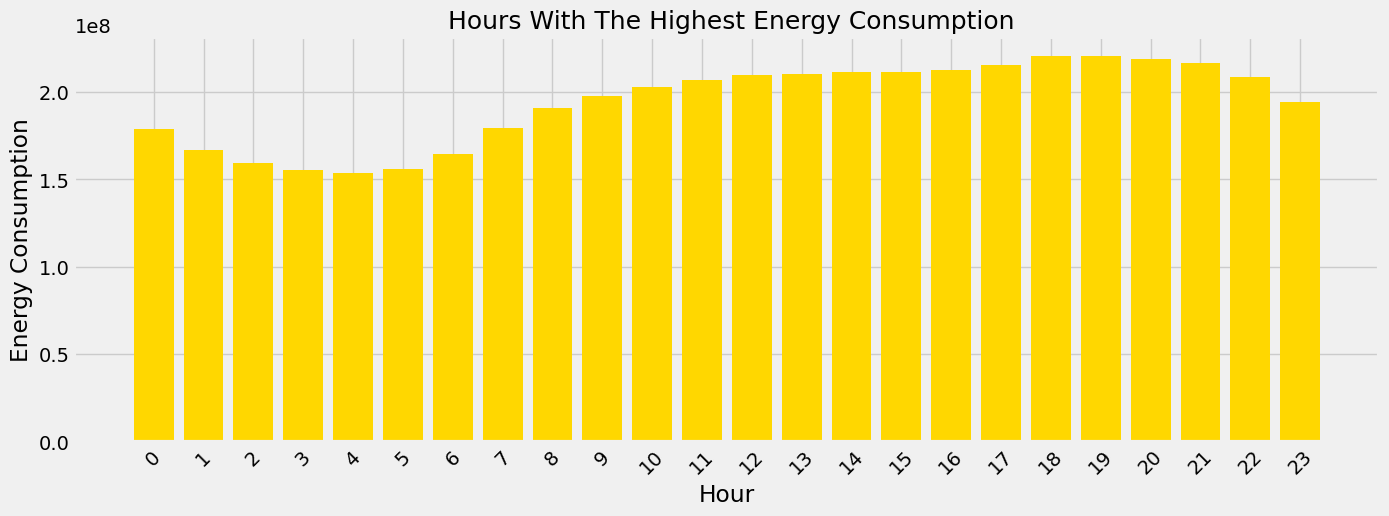

In [288]:
# Hours With The Highest Energy Consumption in Megawatt
hour_ = range(0,24)
plt.figure(figsize=(15, 5))
plt.bar(hour_,df_hour, color='gold')
plt.xticks(hour_)
plt.ylabel('Energy Consumption')
plt.xlabel('Hour')
plt.title(' Hours With The Highest Energy Consumption', fontsize=18)
plt.xticks(rotation=45)
plt.show()

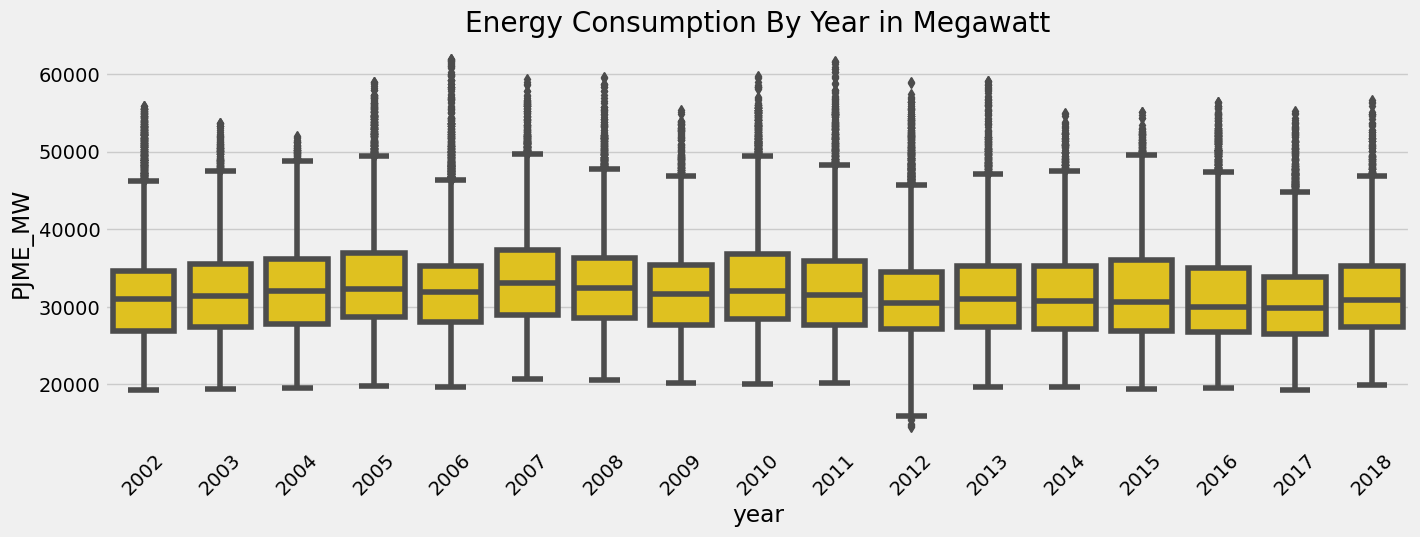

In [289]:
# Analysis : Feature - Target Relationship
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df1, x='year', y='PJME_MW', color ='gold')
ax.set_title('Energy Consumption By Year in Megawatt')
plt.xticks(rotation=45)
plt.show()

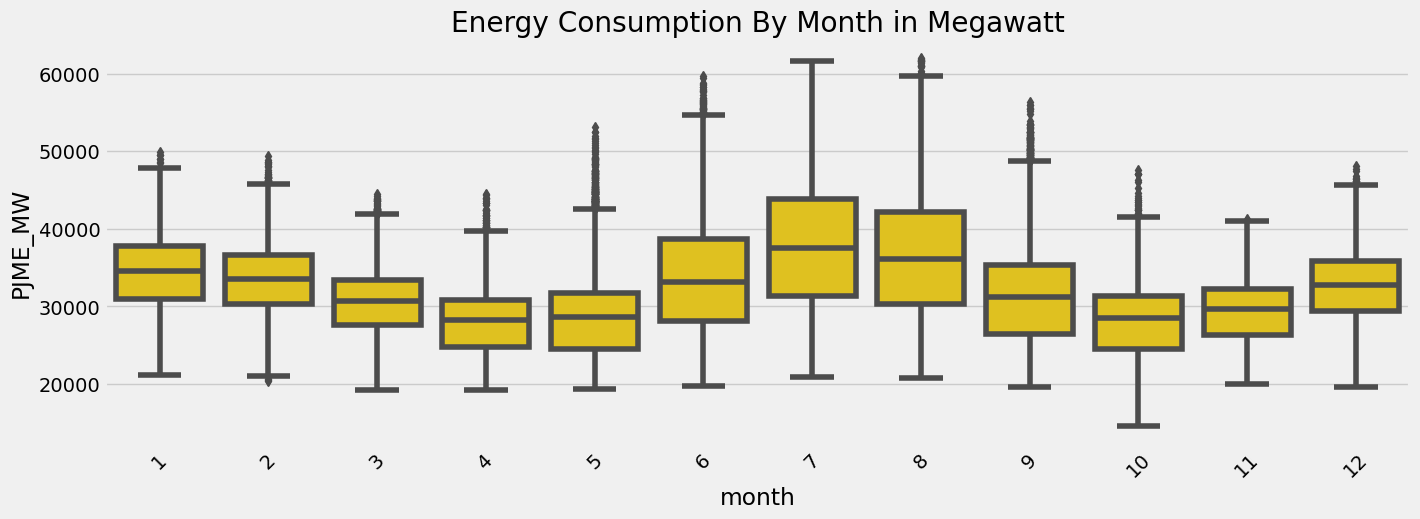

In [290]:
# Analysis : Feature - Target Relationship
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df1, x='month', y='PJME_MW' , color ='gold')
ax.set_title('Energy Consumption By Month in Megawatt')
plt.xticks(rotation=45)
plt.show()

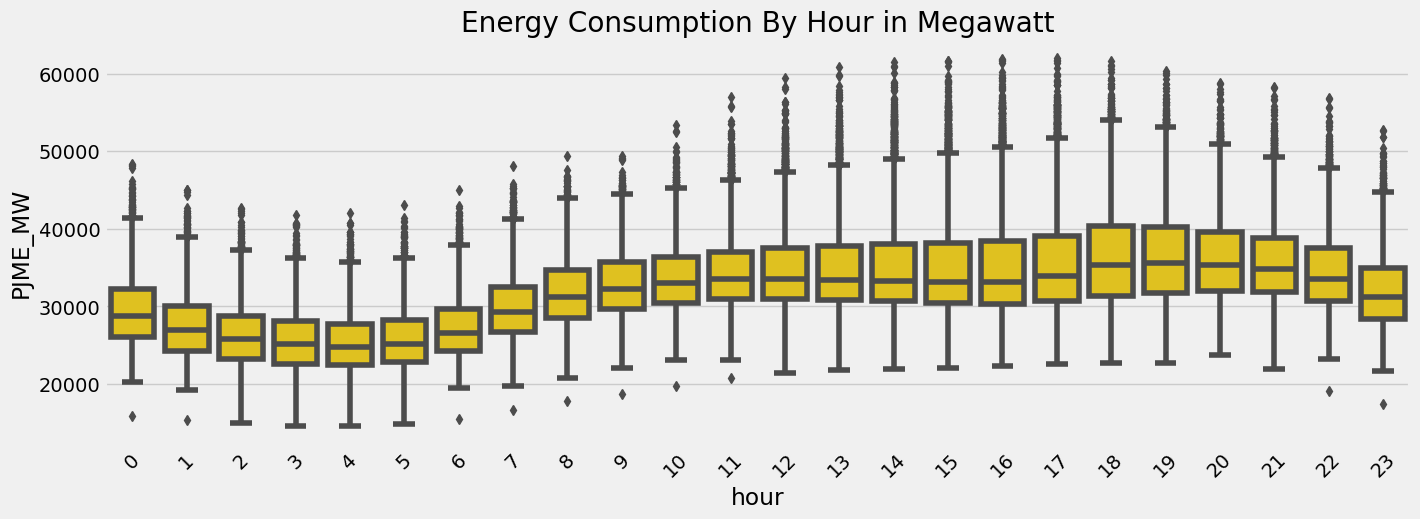

In [291]:
# Analysis : Feature - Target Relationship
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df1, x='hour', y='PJME_MW', color ='gold')
ax.set_title('Energy Consumption By Hour in Megawatt')
plt.xticks(rotation=45)
plt.show()

In [292]:
data = df1.drop(['quarter','day_of_year','week_of_year','day_of_month'],axis=1).corr()
data.head()

,PJME_MW,hour,day_of_week,month,year
PJME_MW,1.000000,0.486303,-0.183058,-0.044522,-0.058505
hour,0.486303,1.000000,0.000317,-0.000049,-0.000131
day_of_week,-0.183058,0.000317,1.000000,-0.000086,-0.000035
month,-0.044522,-0.000049,-0.000086,1.000000,-0.043370
year,-0.058505,-0.000131,-0.000035,-0.043370,1.000000


<AxesSubplot:>

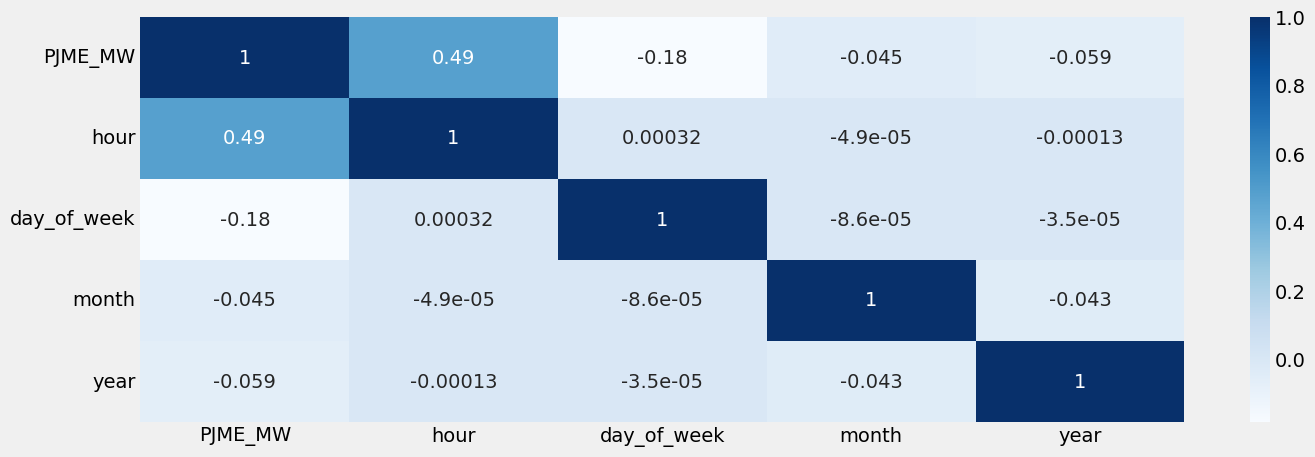

In [293]:
# Correlation Analysis
plt.figure(figsize=(15, 5))
sns.heatmap(data=data, annot=True, cmap='Blues')

## XGBoost Model :

In [294]:
# Train-Test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#### Cut off the data after 2015 to use as our validation set.

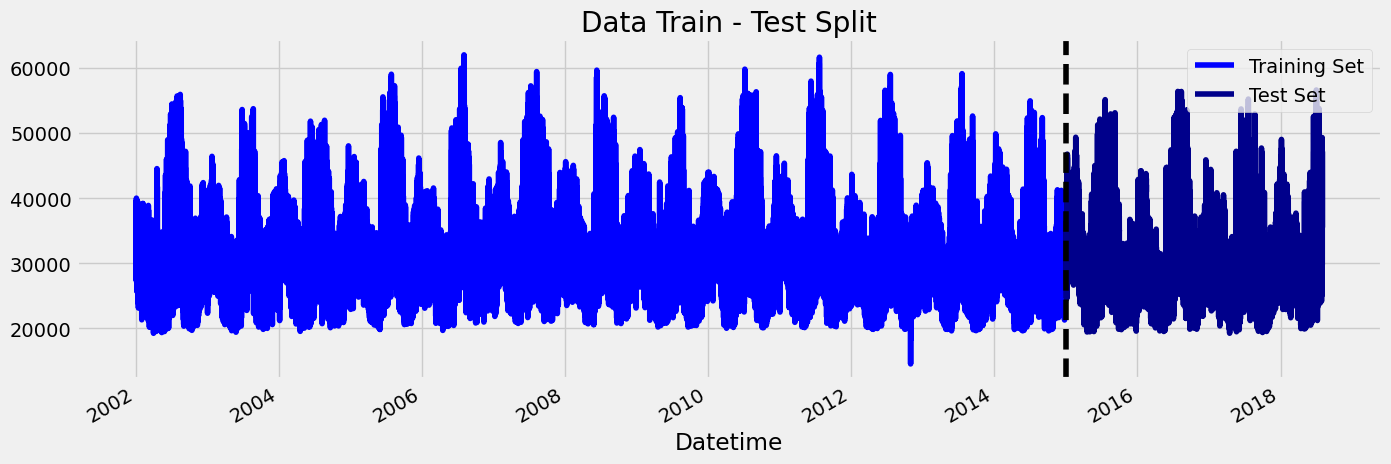

In [295]:
# Analysis : Evolution Of Training Set and Test Set from 2002-2018 
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', color= "blue",title='Data Train - Test Split')
test.plot(ax=ax, label='Test Set',color= "darkblue")
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [296]:
# Create XGBoost Model
train = create_features(train)
test = create_features(test)

FEATURES = ['day_of_year', 'hour', 'day_of_week', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [297]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[04:13:19] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importances : 
- Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

- We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

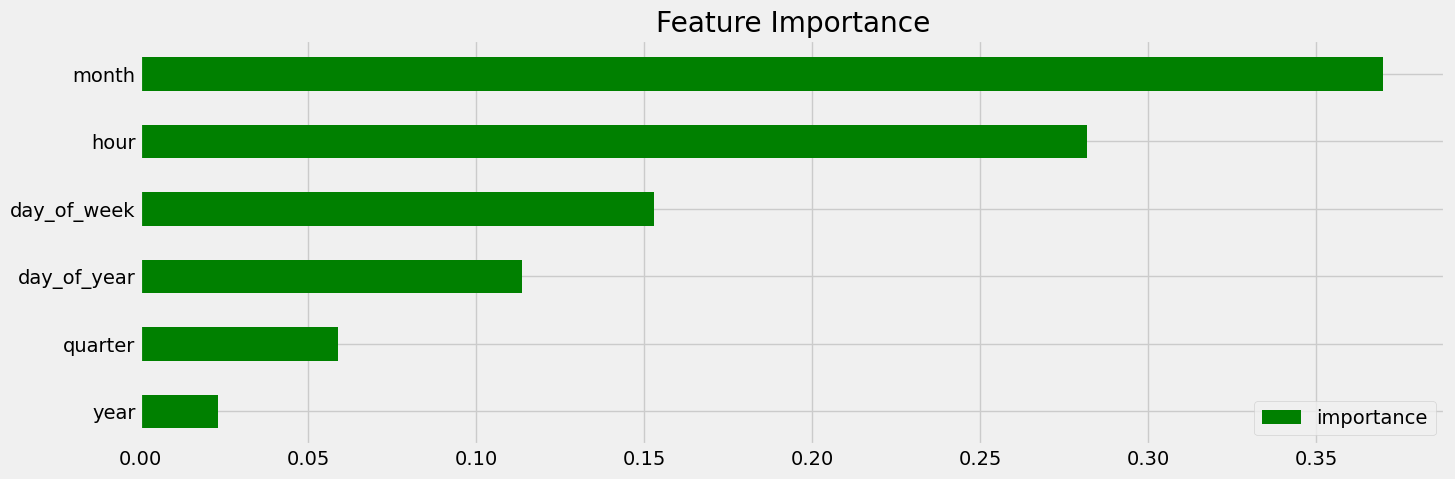

In [298]:
# Analysis : Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot(figsize=(15, 5), kind='barh', title='Feature Importance', color='green')
plt.show()

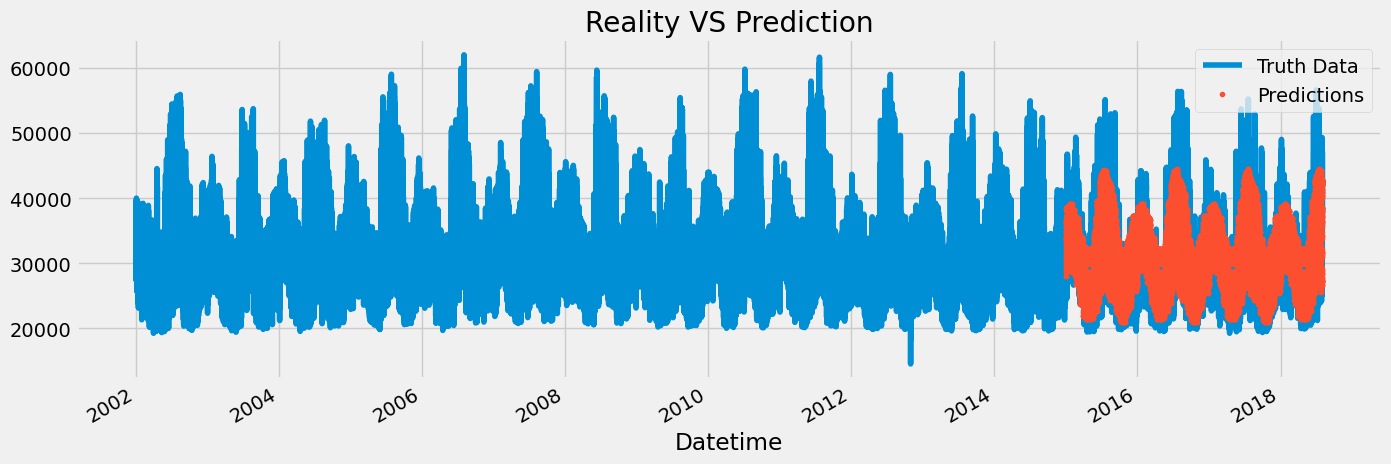

In [299]:
# Cheaking Test Forecasting 
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Reality VS Prediction')
plt.show()

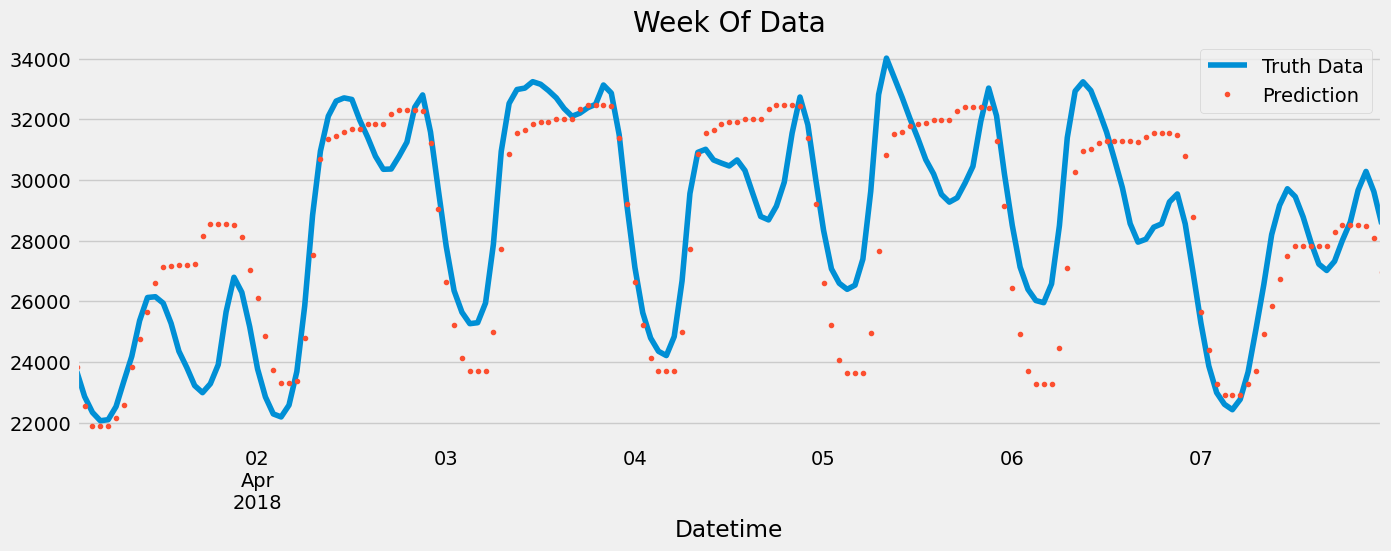

In [300]:
# Look at one week (04-01-2018/04-08-2018 ) of predictions
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Model Evaluation :

In [301]:
# Calculate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

In [302]:
# MSE
mean_squared_error(y_true=test['PJME_MW'] ,
                   y_pred=test['prediction'])

13851395.833873102

In [303]:
# RMSE
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


In [304]:
# MAE
mean_absolute_error(y_true=test['PJME_MW'] ,
                   y_pred=test['prediction'])

2895.3947107213144

In [305]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [306]:
mean_absolute_percentage_error(y_true=test['PJME_MW'] ,
                   y_pred=test['prediction'])

9.139058448639418

#### Look at the Worst and Best predicted days

In [307]:
# Worst absolute predicted days
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

In [308]:
# Best predicted days
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    349.390462
2015-10-28    397.410807
2016-10-27    528.968913
2015-05-06    529.528971
2017-10-15    535.292318
2018-05-16    585.349935
2016-10-08    625.825439
2015-10-03    653.130941
2016-09-16    656.402995
2015-11-06    674.912109
Name: error, dtype: float64